<a href="https://colab.research.google.com/github/meichenfang/Poisson-regression/blob/main/demos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font size="+4"><center> Demonstrations </center></font> 

# Load packages

In [1]:
%cd ../RADOM

# restrict numpy to use only one core, otherwise it will use all cores when doing @
import os
os.environ["BLAS_NUM_THREADS"] = "1" 
os.environ["OPENBLAS_NUM_THREADS"] = "1" # 


from inference import Trajectory
from plotting import *
from models.two_species_tau import get_Y

/home/mffang/workspace/Poisson-regression/RADOM


In [2]:
import numpy as np
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy import stats
import copy

In [3]:
%cd ../simulation_results
results_dir = 'two_species_tau/'

if not os.path.exists(results_dir):
    os.makedirs(results_dir)

/home/mffang/workspace/Poisson-regression/simulation_results


In [4]:
tau_max = 0.3
loga_max = 4
logb_var = 1
logb_mu = 1
lambda_tau = 0.1

# Vary p, n and topo

## Functions

### Fit

In [5]:
from multiprocessing import Pool

def fit_wrapper(X,topo_,tau_,true_t,theta,m,n_init):
    traj = Trajectory(topo=topo_, tau=tau_, model="two_species_tau")
    traj.fit(X,m=m,n_init=n_init,params={'lambda_tau':lambda_tau},beta=1,perm_theta=False,epoch=100,parallel=False)   
            
    traj.true_t = true_t
    traj.true_theta = theta
    
    return traj

In [6]:
def fit_vary_n_fixed(topo, tau, ns=[1000,3162,10000], p=100, seed=2023, K=10, n_init=10, m=100, cores=10):
    np.random.seed(seed)
    L = len(topo)     
    n_states=len(set(topo.flatten()))
    n_stages = len(tau)-1

    theta=np.zeros((p,n_states+n_stages+2))
    for j in range(n_states):
        theta[:,j] = np.exp(np.random.uniform(0,loga_max,size=p))-1
    for j in range(n_stages-1):
        theta[:,j+n_states] = tau[j+1] + np.random.uniform(-tau_max,tau_max,size=p)
    theta[:,-2:] = np.exp(np.random.normal(logb_mu,logb_var,size=(p,2)))
    theta[:,-3] = np.exp(np.random.uniform(0,loga_max,size=p))-1

    
    Input_args = []
    for i,n in enumerate(ns):             
        for k in range(K):
            np.random.seed(k)
            true_t = []
            Y = np.zeros((n*L,p,2)) 
            for l in range(L):
                t = np.sort(np.random.uniform(tau[0],tau[-1],n))
                theta_l = np.concatenate((theta[:,topo[l]], theta[:,-n_stages-2:]), axis=1)
                Y[l*n:(l+1)*n] = get_Y(theta_l,t,tau) # m*p*2
                true_t = np.append(true_t,t)
        
            X = np.random.poisson(Y)
            
            Input_args.append((X, topo, tau, true_t, theta, m, n_init))
            
    with Pool(cores) as pool:      
        results = pool.starmap(fit_wrapper, Input_args,chunksize=1)
    
    return results

In [7]:
def fit_vary_p_fixed(topo, tau, n=3162, ps=[31,100,316], seed=2023, K=10, n_init=10, m=100, cores=10):
    np.random.seed(seed)
    L = len(topo)     
    n_states=len(set(topo.flatten()))
    n_stages = len(tau)-1
    
    p_total = int( np.max(ps) )
    theta_all=np.ones((p_total,n_states+n_stages+2))
    for j in range(n_states):
        theta_all[:,j]=np.exp(np.random.uniform(0,loga_max,size=p_total))-1
    for j in range(n_stages-1):
        theta_all[:,j+n_states]=tau[j+1]+np.random.uniform(-tau_max,tau_max,size=p_total)
    theta_all[:,-3]=np.exp(np.random.uniform(0,loga_max,size=p_total))-1
    theta_all[:,-2:]=np.exp(np.random.normal(logb_mu,logb_var,size=(p_total,2)))

    
    Input_args = []
    for i,p in enumerate(ps):   
          
        Y = np.zeros((n*L,p,2))
        theta = theta_all[:p]
        
        for k in range(K):
            np.random.seed(k)
            true_t = []
            for l in range(L):
                #t=np.linspace(tau[0],tau[-1],n)
                t = np.sort(np.random.uniform(tau[0],tau[-1],n))
                theta_l = np.concatenate((theta[:,topo[l]], theta[:,-n_stages-2:]), axis=1)
                Y[l*n:(l+1)*n] = get_Y(theta_l,t,tau) # m*p*2
                true_t = np.append(true_t,t)
        
            X = np.random.poisson(Y)
            
            Input_args.append((X, topo, tau, true_t, theta, m, n_init))
        
    with Pool(cores) as pool:      
        results = pool.starmap(fit_wrapper, Input_args,chunksize=1)
                
    return results

### Plot results

In [17]:
plt.rcParams['font.size'] = '24'
label_font = '36'

In [9]:
def plot_t_results(picklefile,K=10):
    with open(picklefile, 'rb') as f:
        results = pickle.load(f)
    test = results[0]
    L = len(test.topo)
    if hasattr(test,"elbos"):
        print("n_init = ",len(test.elbos))
    fig, axs = plt.subplots(len(results)//K,L*K,figsize=(L*K*6,len(results)//K*5))
    
    for i in range(len(results)):
        traj = results[i]
        Q = traj.Q.copy()
        N,p,_ = traj.X.shape
        n = N//L
        
        if L==2:
            if np.sum(Q[:n,0])<np.sum(Q[:n,1]):
                Q[:,0] = traj.Q[:,1]
                Q[:,1] = traj.Q[:,0]

        for l in range(L):
            plot_t(traj,Q=Q,l=l,ax=axs[i//K,L*(i%K)+l],t=traj.true_t)
            
    #fig.supxlabel('time grids',fontsize=label_font);
    #fig.supylabel('ordered cells',fontsize=label_font);
    return fig

In [10]:
def plot_theta_results(picklefile,K=10):
    with open(picklefile, 'rb') as f:
        results = pickle.load(f)
    test = results[0]
    p, n_theta = test.theta.shape
    fig, ax = plt.subplots(len(results)//K,n_theta,figsize=(n_theta*6,len(results)//K*5),constrained_layout=True)

    for i in range(len(results)):
        traj = results[i]
        true_theta = traj.true_theta.copy()
        Q = traj.Q
        N,p,_ = traj.X.shape
        
        if len(traj.topo)==2:
            n = N//2
            if np.sum(Q[:n,0])<np.sum(Q[:n,1]):
                true_theta[:,traj.topo[0]] = traj.true_theta[:,traj.topo[1]]
                true_theta[:,traj.topo[1]] = traj.true_theta[:,traj.topo[0]]

        for j in range(n_theta):
            ax[i//K,j].loglog(true_theta[:,j],traj.theta[:,j],'.');
            
    for i in range(len(results)//K):
        for j in range(n_theta):
            ax[i,j].loglog(true_theta[:,j],true_theta[:,j],'gray');        
    
    n_stages = len(traj.tau)-1
    for j in range(n_theta-3):
        ax[0,j].set_title("α"+str(j),fontsize=label_font)    
    for j in range(-n_stages-2,-3):
        ax[0,j].set_title("τ"+str(j+n_stages+3),fontsize=label_font)    
        
    ax[0,-3].set_title("s0",fontsize=label_font)
    ax[0,-2].set_title("β",fontsize=label_font)
    ax[0,-1].set_title("γ",fontsize=label_font)
    fig.supxlabel('true value',fontsize=label_font);
    fig.supylabel('estimates',fontsize=label_font);
    return fig

In [11]:
def plot_vary_n_results(picklefile,ns=[100,316,1000,3162,10000],K=10,llim=1e-4,hlim=1e3):
    with open(picklefile, 'rb') as f:
        results = pickle.load(f)
    test = results[0]
    p, n_theta = test.theta.shape
    
    abs_err = np.zeros((len(ns),K,p,n_theta))
    rel_err = np.zeros((len(ns),K,p,n_theta))
    for i in range(len(results)):
        traj = results[i]
        true_theta = traj.true_theta.copy()
        Q = traj.Q
        N,p,_ = traj.X.shape
        
        if len(traj.topo)==2:
            n = N//2
            if np.sum(Q[:n,0])<np.sum(Q[:n,1]):
                true_theta[:,traj.topo[0]] = traj.true_theta[:,traj.topo[1]]
                true_theta[:,traj.topo[1]] = traj.true_theta[:,traj.topo[0]]

        abs_err[i//K,i%K]=np.abs(traj.theta-true_theta)
        rel_err[i//K,i%K]=np.abs(traj.theta-true_theta)/true_theta

    fig, ax = plt.subplots(1,n_theta,figsize=(n_theta*6,5),constrained_layout=True)
    for i in range(p):
        for j in range(n_theta):
            ax[j].loglog(ns,rel_err[:,:,i,j].mean(axis=1),alpha=0.1);

    n_stages = len(traj.tau)-1
    for j in range(n_theta-3):
        ax[j].set_title("α"+str(j),fontsize=label_font)    
    for j in range(-n_stages-2,-3):
        ax[j].set_title("τ"+str(j+n_stages+3),fontsize=label_font)    

    ax[-3].set_title("s0",fontsize=label_font)
    ax[-2].set_title("β",fontsize=label_font)
    ax[-1].set_title("γ",fontsize=label_font)
    plt.setp(ax, ylim=(llim,hlim));
    fig.supylabel('relative error',fontsize=label_font);
    fig.supxlabel('number of cells',fontsize=label_font);

    """
    fig, ax = plt.subplots(1,5,figsize=(5*6,5),constrained_layout=True)
    for j in range(5):
        ax[j].loglog(ns,rel_err[:,:,:,j].mean(axis=(1,2)));

    ax[0].set_title("α1")
    ax[1].set_title("u0")
    ax[2].set_title("s0")
    ax[3].set_title("β")
    ax[4].set_title("γ")
    plt.setp(ax, ylim=(0.1,10));
    fig.supxlabel('number of cells n');
    fig.supylabel('relative error');
    """
    return fig

In [12]:
def plot_vary_p_results(picklefile,ps=[31,100,316],K=10,llim=1e-4,hlim=1e3):
    with open(picklefile, 'rb') as f:
        results = pickle.load(f)
    test = results[-1]
    p, n_theta = test.theta.shape

    abs_err = np.zeros((len(ps),K,p,n_theta))
    rel_err = np.zeros((len(ps),K,p,n_theta))
    for i in range(len(results)):
        traj = results[i]
        true_theta = traj.true_theta.copy()
        Q = traj.Q
        p = ps[i//K]
        N = traj.X.shape[0]
       
        if len(traj.topo)==2:
            n = N//2
            if np.sum(Q[:n,0])<np.sum(Q[:n,1]):
                true_theta[:,traj.topo[0]] = traj.true_theta[:,traj.topo[1]]
                true_theta[:,traj.topo[1]] = traj.true_theta[:,traj.topo[0]]

        rel_err[i//K,i%K,:p] = np.abs(traj.theta-true_theta)/true_theta

    fig, ax = plt.subplots(1,n_theta,figsize=(n_theta*6,5),constrained_layout=True)
    last_p = 0
    for i,p in enumerate(ps):
        for j in range(n_theta):
            ax[j].loglog(ps[i:],rel_err[i:,:,last_p:p,j].mean(axis=1),alpha=0.1);
        last_p = p

    n_stages = len(traj.tau)-1
    for j in range(n_theta-3):
        ax[j].set_title("α"+str(j),fontsize=label_font)    
    for j in range(-n_stages-2,-3):
        ax[j].set_title("τ"+str(j+n_stages+3),fontsize=label_font)    
    
    ax[-3].set_title("s0",fontsize=label_font)
    ax[-2].set_title("β",fontsize=label_font)
    ax[-1].set_title("γ",fontsize=label_font)
    plt.setp(ax, ylim=(llim,hlim));
    fig.supylabel('relative error',fontsize=label_font);
    fig.supxlabel('number of genes',fontsize=label_font);

    """
    fig, ax = plt.subplots(1,5,figsize=(5*6,5),constrained_layout=True)
    for j in range(5):
        ax[j].loglog(ns,rel_err[:,:,:,j].mean(axis=(1,2)));

    ax[0].set_title("α1")
    ax[1].set_title("u0")
    ax[2].set_title("s0")
    ax[3].set_title("β")
    ax[4].set_title("γ")
    plt.setp(ax, ylim=(0.1,10));
    fig.supxlabel('number of cells n');
    fig.supylabel('relative error');
    """
    return fig

## Topo 2: one lineage with two transitions

### vary n

In [13]:
topo = np.array([[0,1,2]])
tau = (0,1,2)
results = fit_vary_n_fixed(topo, tau, ns=[1000,3162,10000], p=100, seed=1, K=10, n_init=10, m=100, cores=10)

with open(results_dir+'topo_2_vary_n_1_L01.pickle', 'wb') as f:
    pickle.dump(results, f, pickle.HIGHEST_PROTOCOL)

n_init =  10


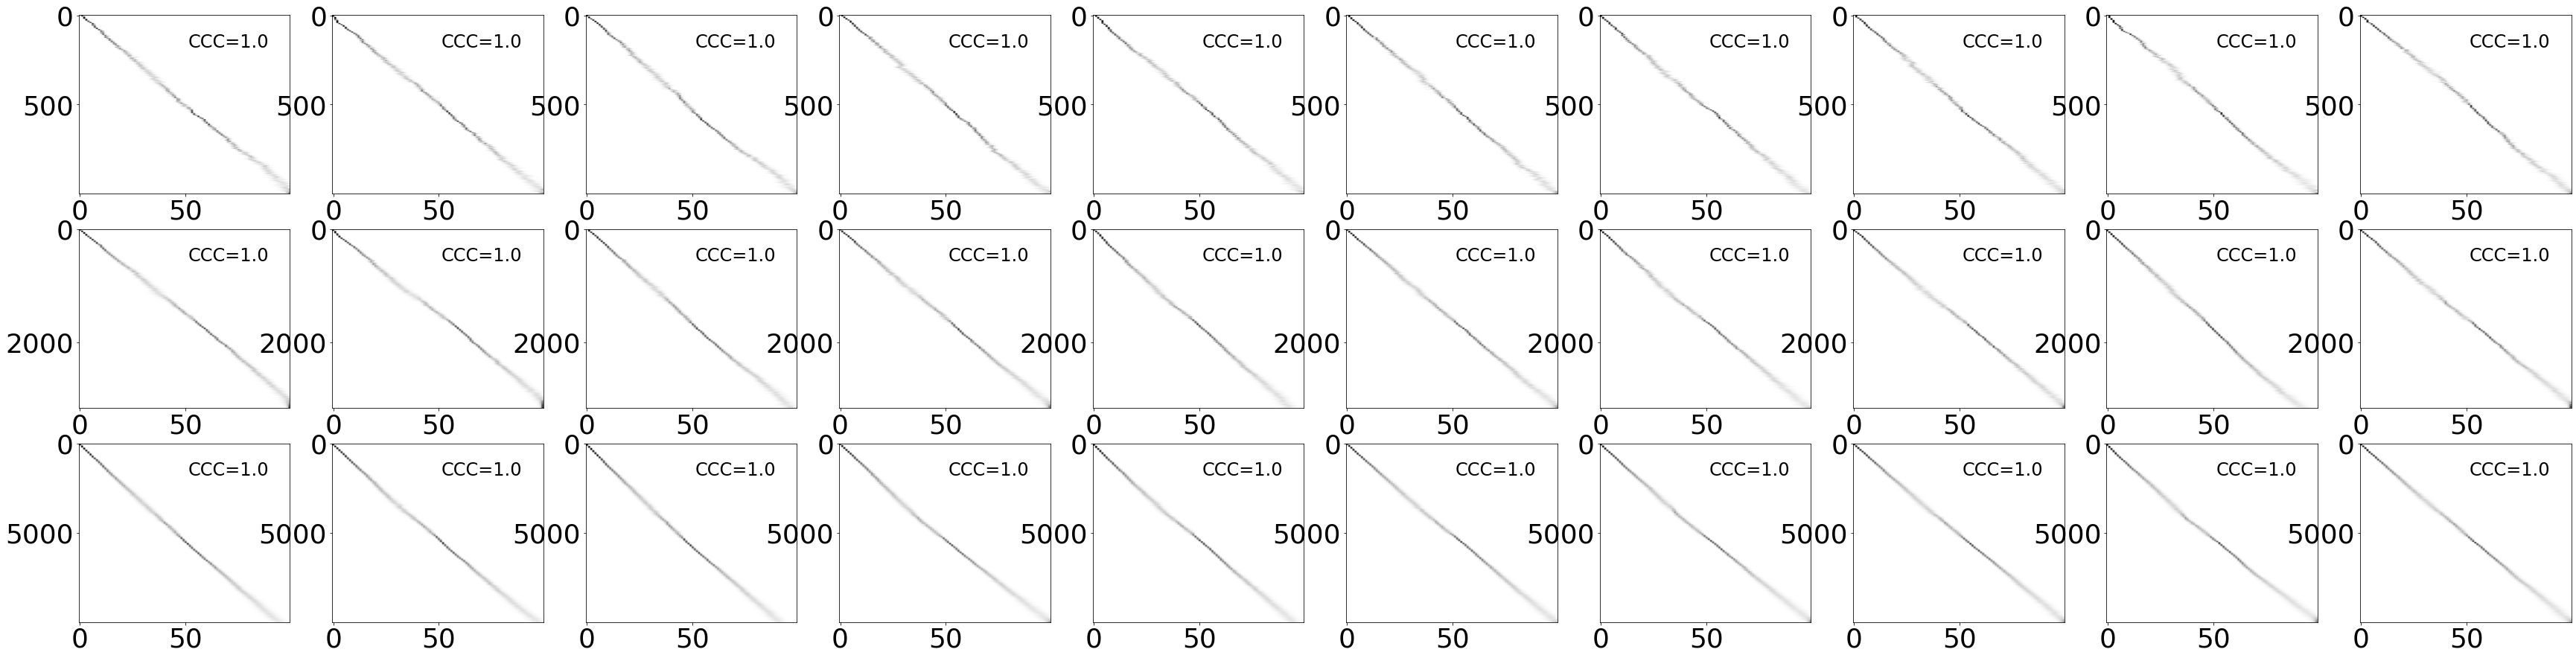

In [21]:
fig = plot_t_results(results_dir+'topo_2_vary_n_1_L01.pickle',K=10)

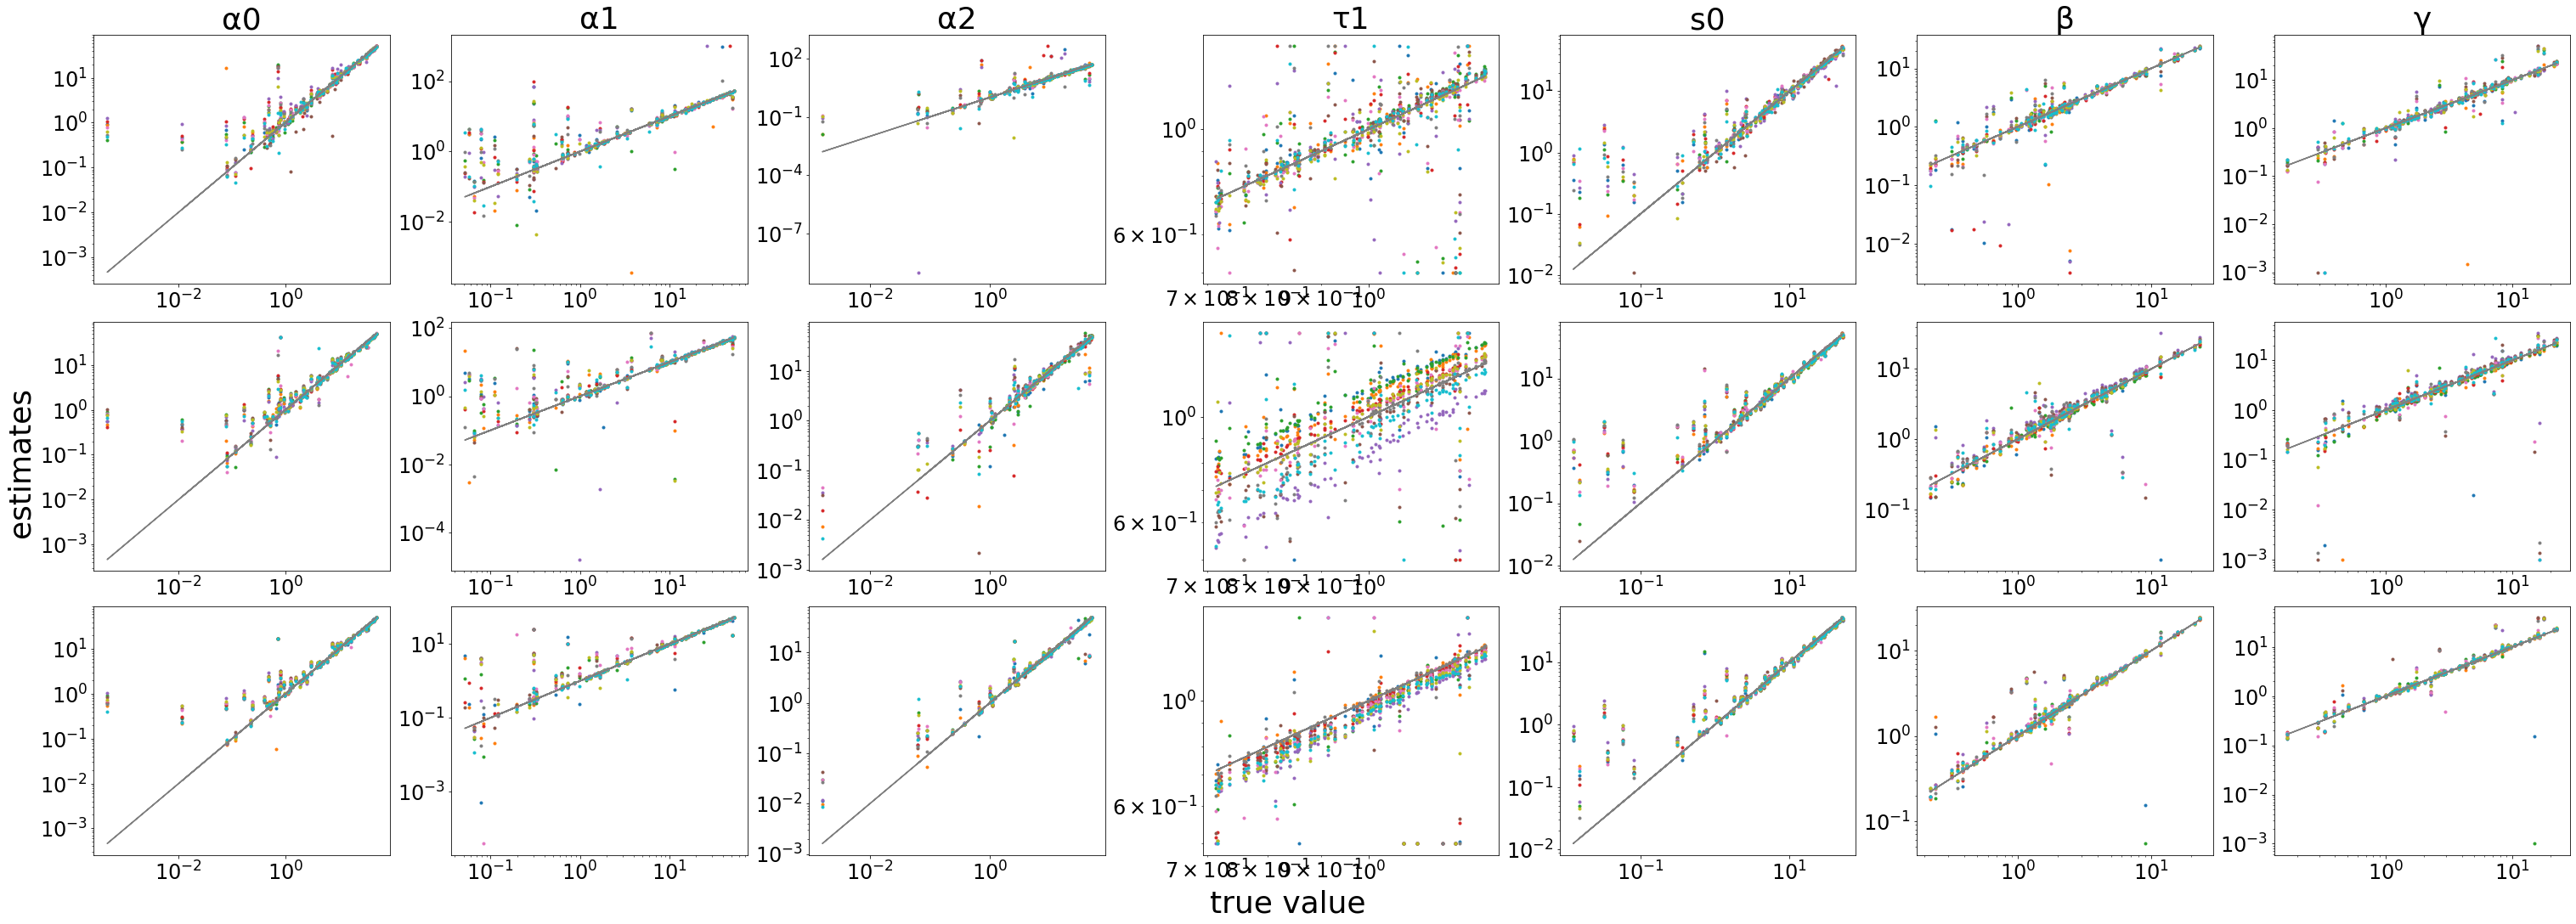

In [66]:
fig = plot_theta_results(results_dir+'topo_2_vary_n_1.pickle')

In [28]:
plt.rcParams['font.size'] = '30'
label_font = '48'

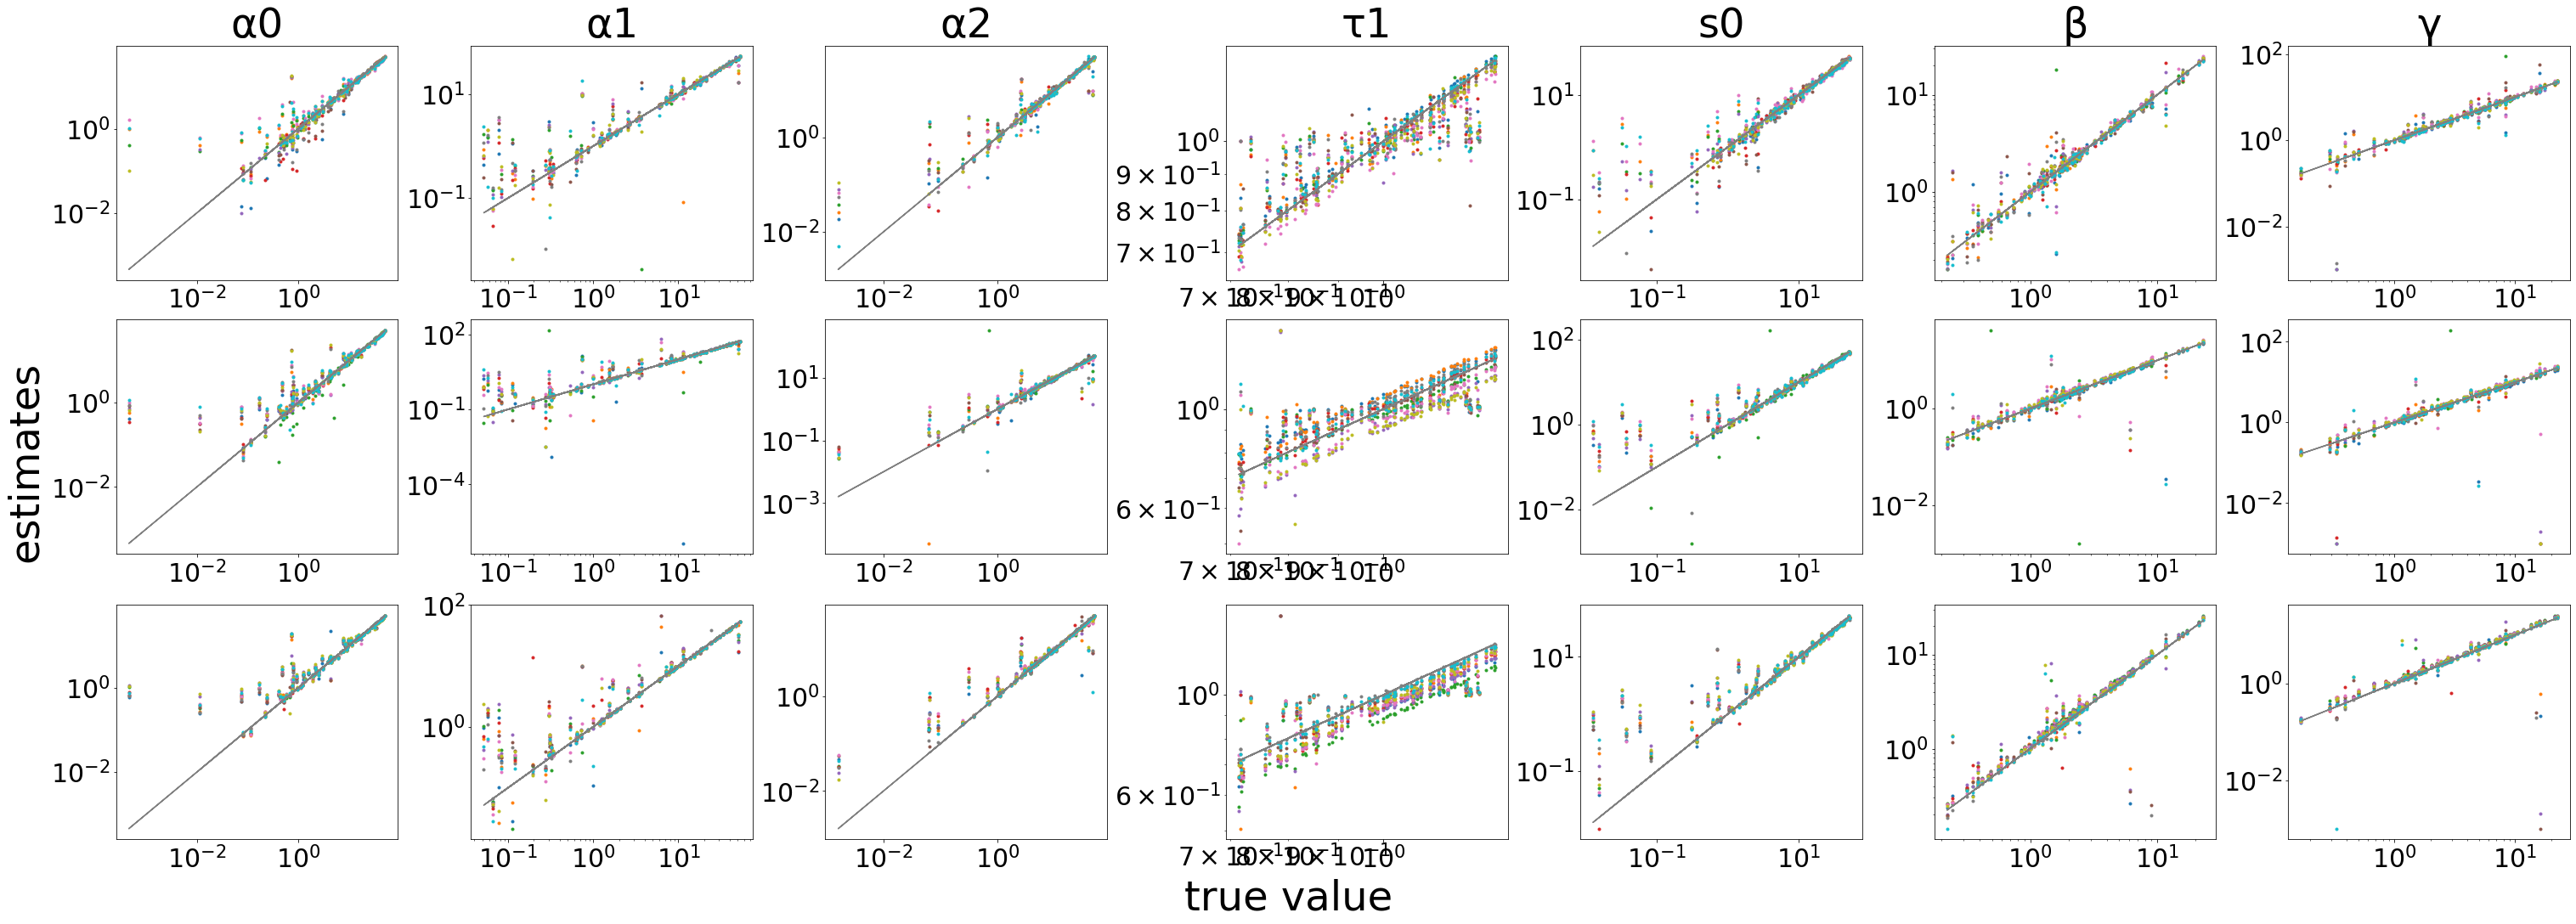

In [29]:
fig = plot_theta_results(results_dir+'topo_2_vary_n_1_L01.pickle')

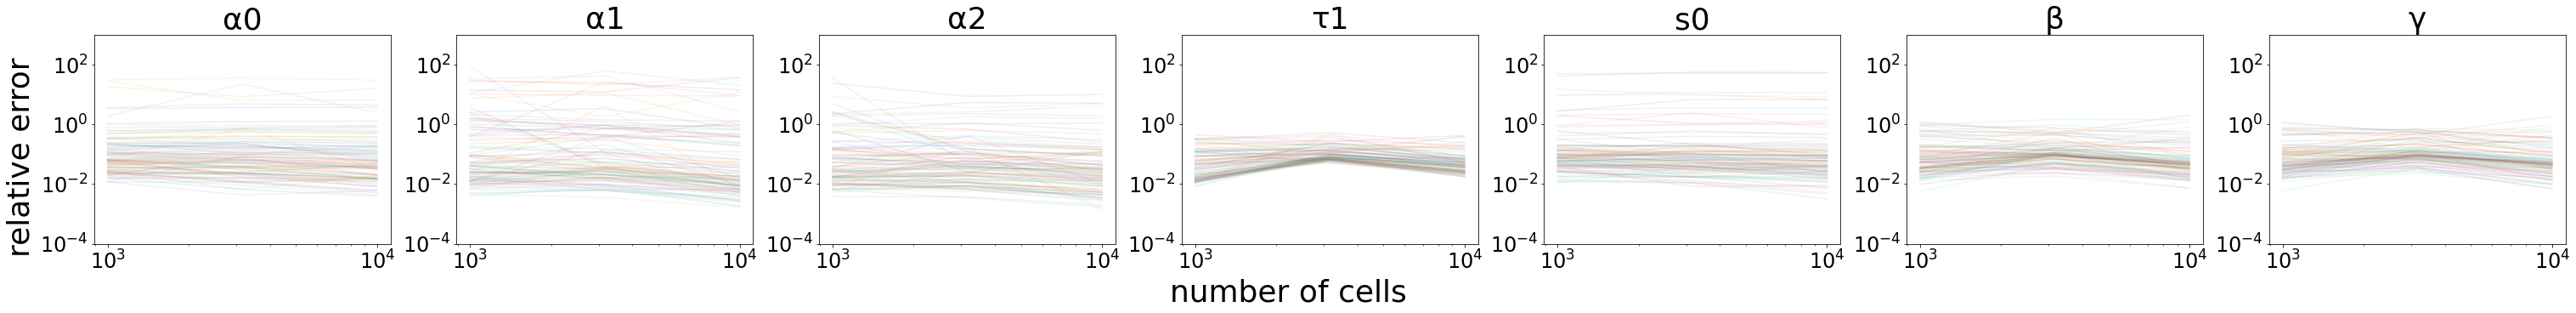

In [89]:
fig = plot_vary_n_results(results_dir+'topo_2_vary_n_1.pickle',ns=[1000,3162,10000],K=10,llim=1e-4,hlim=1e3)

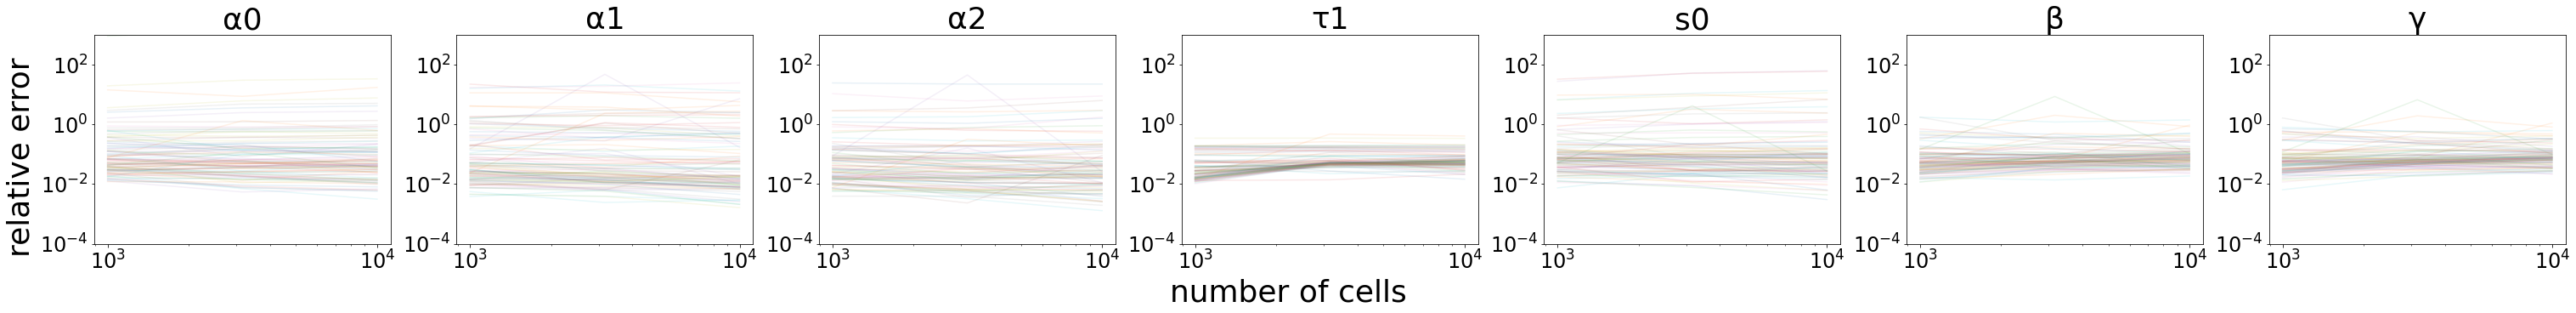

In [18]:
fig = plot_vary_n_results(results_dir+'topo_2_vary_n_1_L01.pickle',ns=[1000,3162,10000],K=10,llim=1e-4,hlim=1e3)

### vary p

In [ ]:
topo = np.array([[0,1,2]])
tau = (0,1,2)
results = fit_vary_p_fixed(topo, tau, n=1000, ps=[31,100,316], seed=1, K=10, n_init=10, m=100, epoch=10, cores=30)

with open(results_dir+'topo_2_vary_p_1.pickle', 'wb') as f:
    pickle.dump(results, f, pickle.HIGHEST_PROTOCOL)

n_init =  10


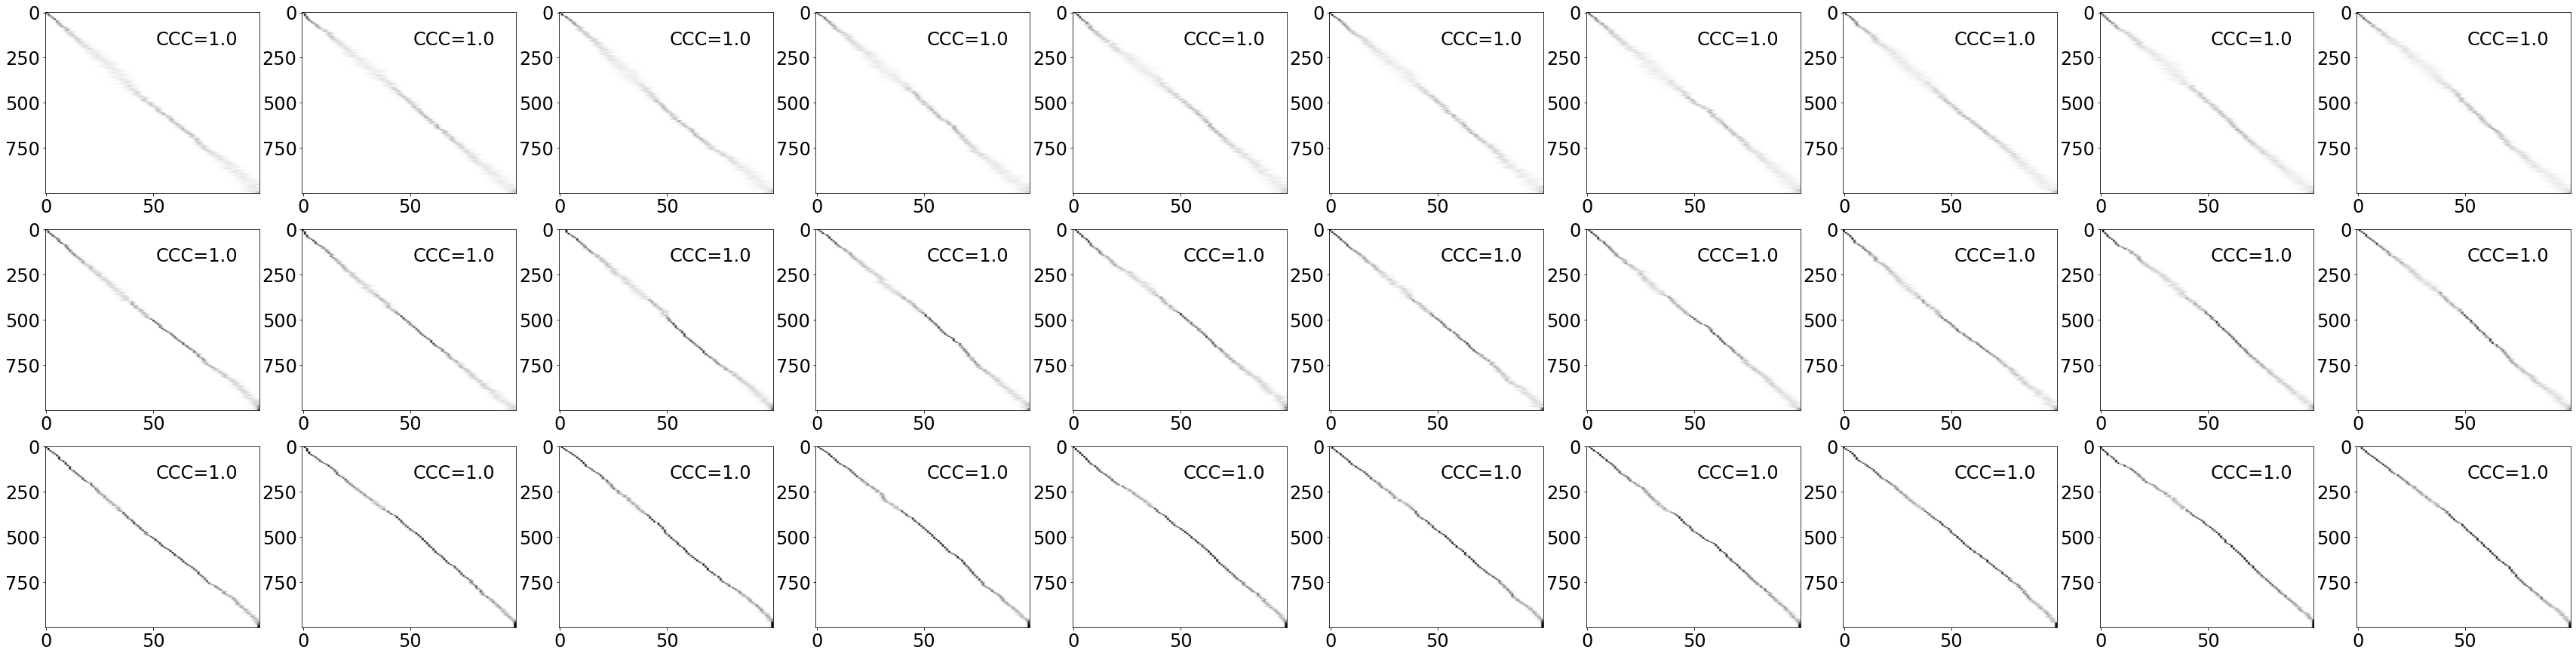

In [72]:
fig = plot_t_results(results_dir+'topo_2_vary_p_1.pickle')

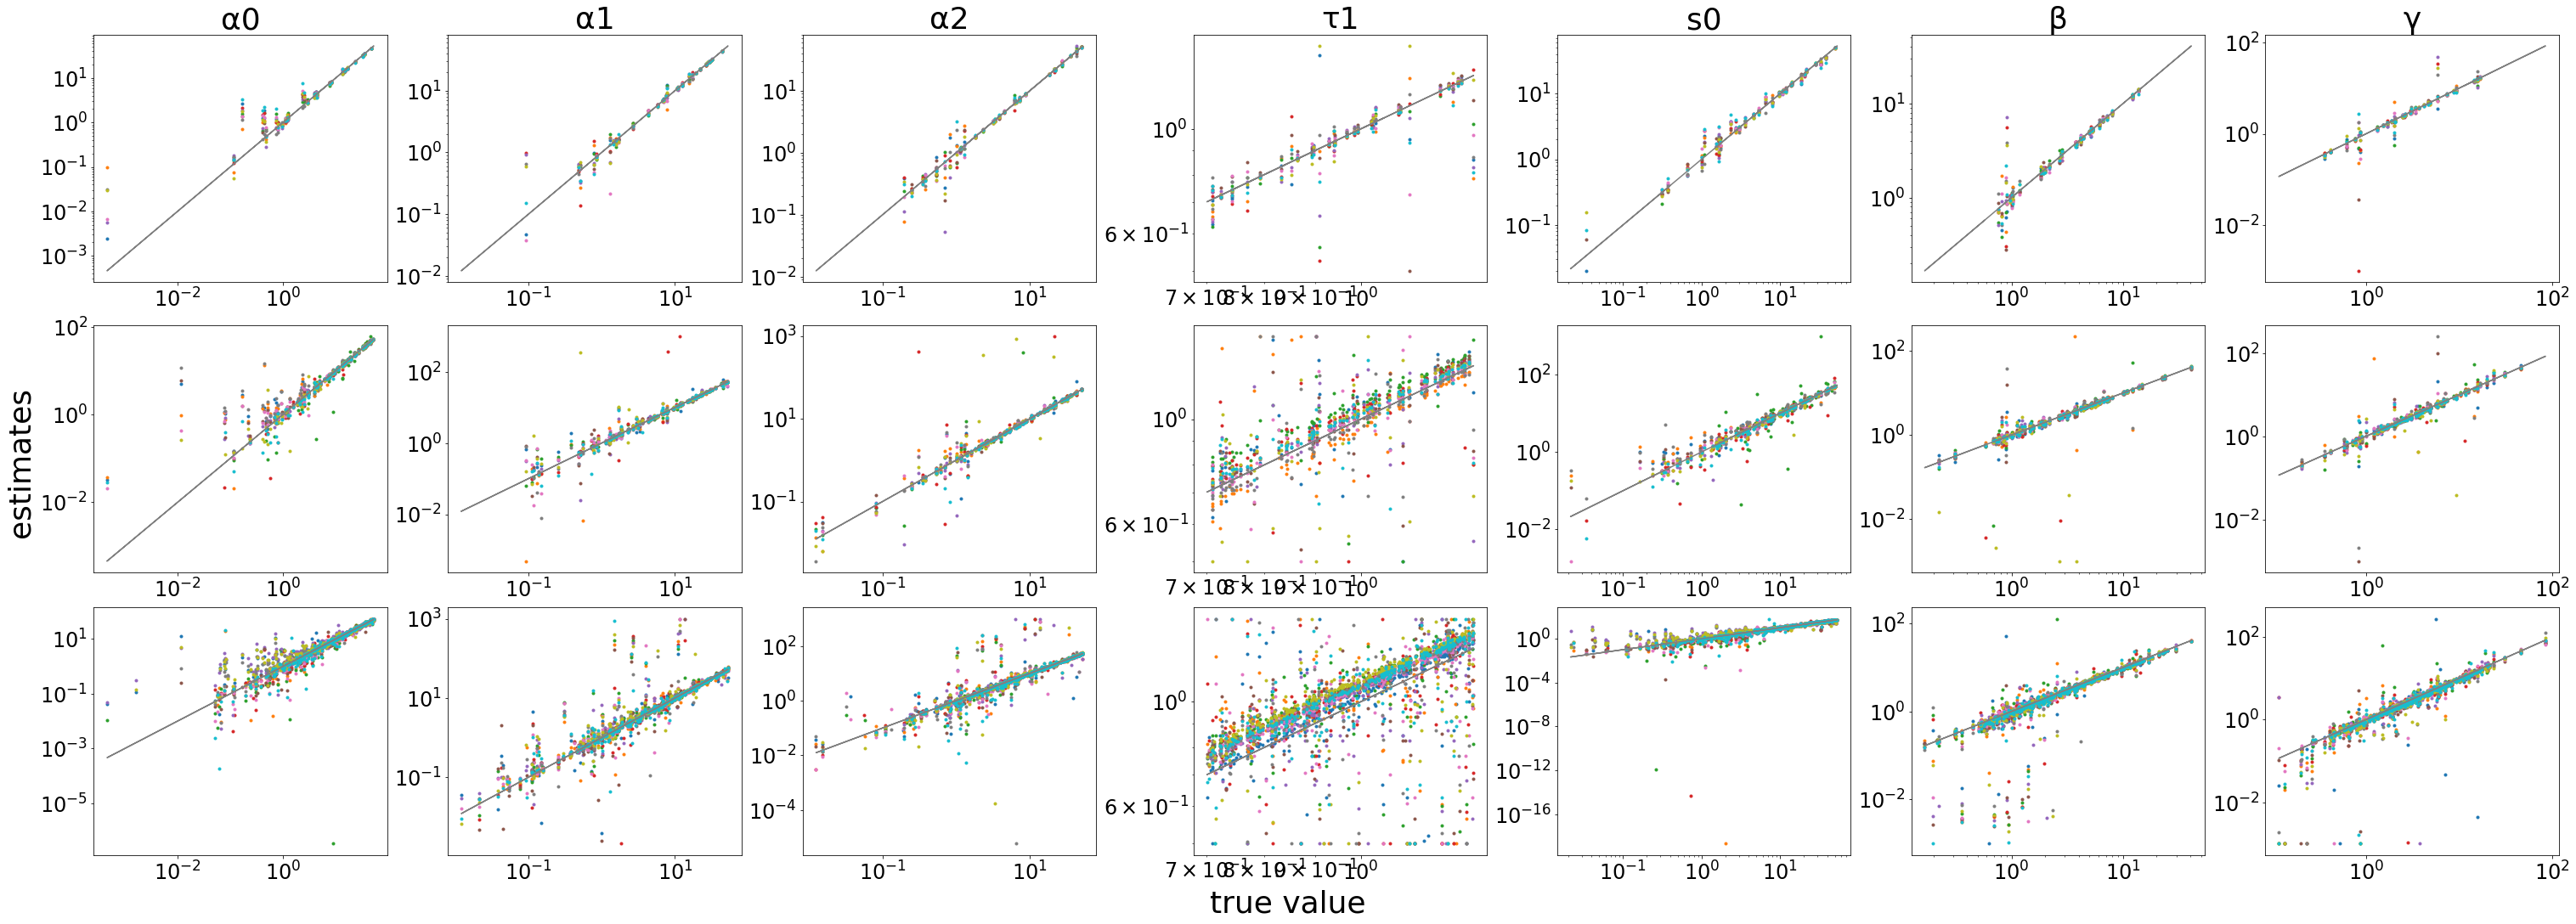

In [73]:
fig = plot_theta_results(results_dir+'topo_2_vary_p_1.pickle', K=10)

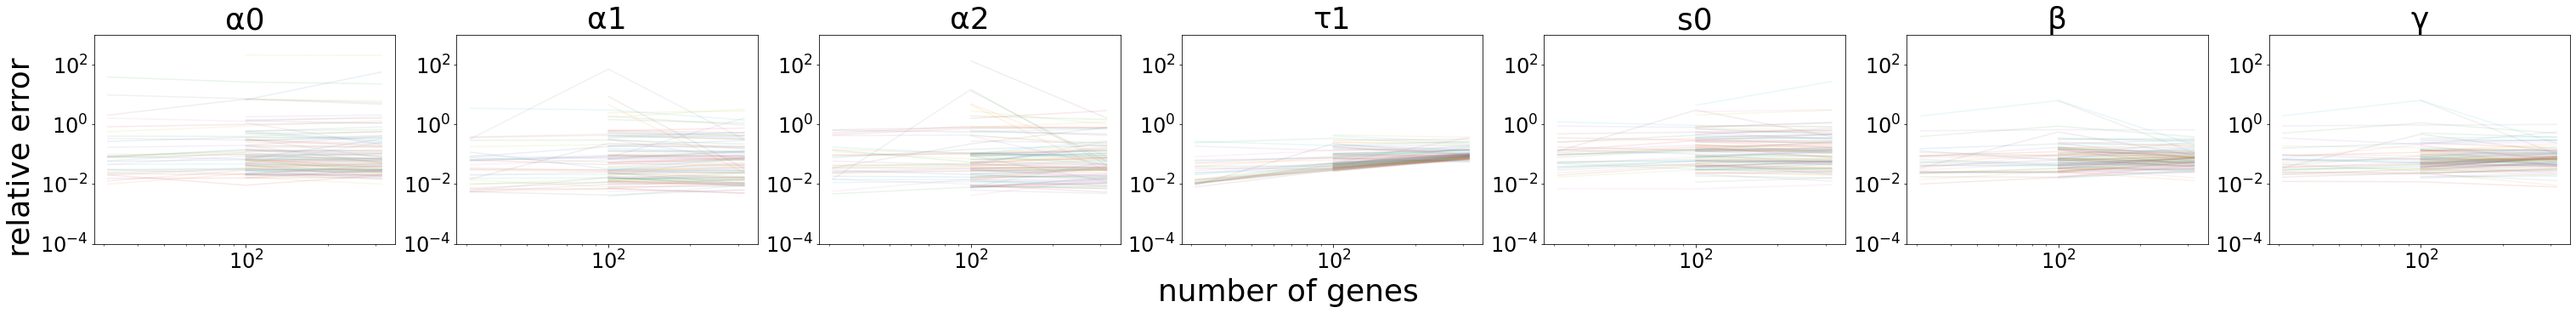

In [86]:
fig = plot_vary_p_results(results_dir+'topo_2_vary_p_1.pickle', ps=[31,100,316], K=10)

## Topo 4 : two lineages (bifurcation)

### topo 4 vary n

In [ ]:
topo = np.array([[0,1,2],[0,1,3]])
tau = (0,1,2)
results = fit_vary_n_fixed(topo, tau, ns=[1000,3162,10000], p=100, seed=1, K=10, n_init=20, m=100, epoch=10, cores=30)

with open(results_dir+'topo_4_vary_n_1.pickle', 'wb') as f:
    pickle.dump(results, f, pickle.HIGHEST_PROTOCOL)

n_init =  20


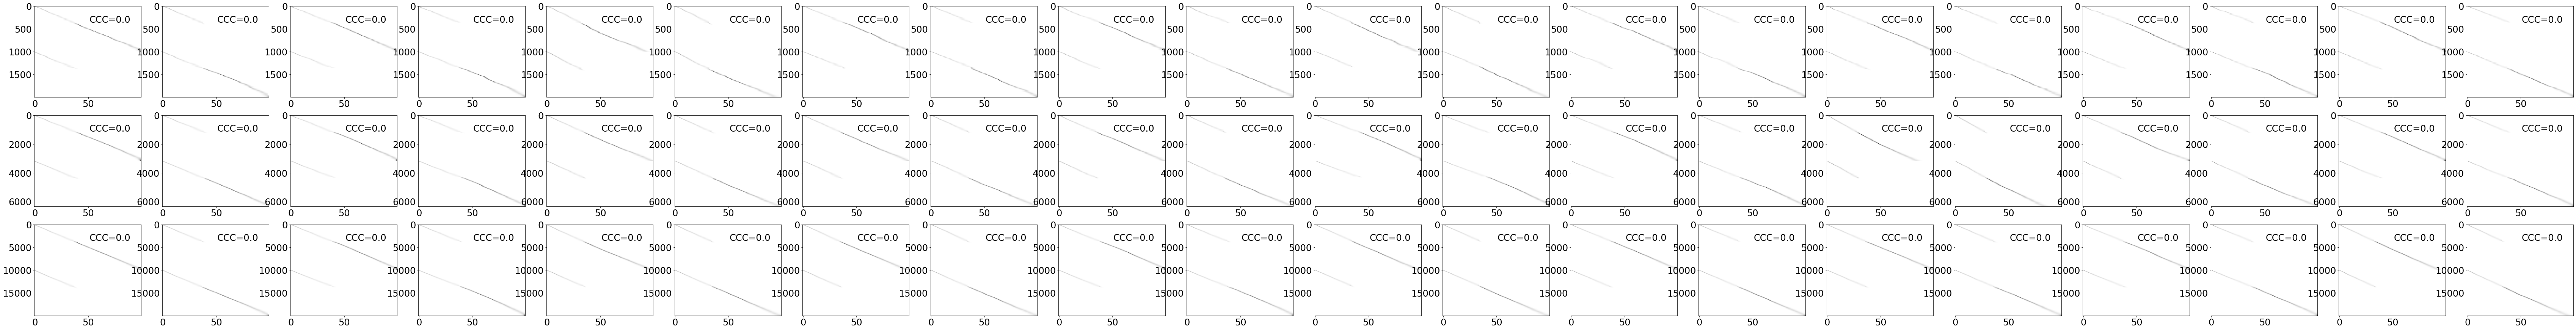

In [75]:
fig = plot_t_results(results_dir+'topo_4_vary_n_1.pickle',K=10)

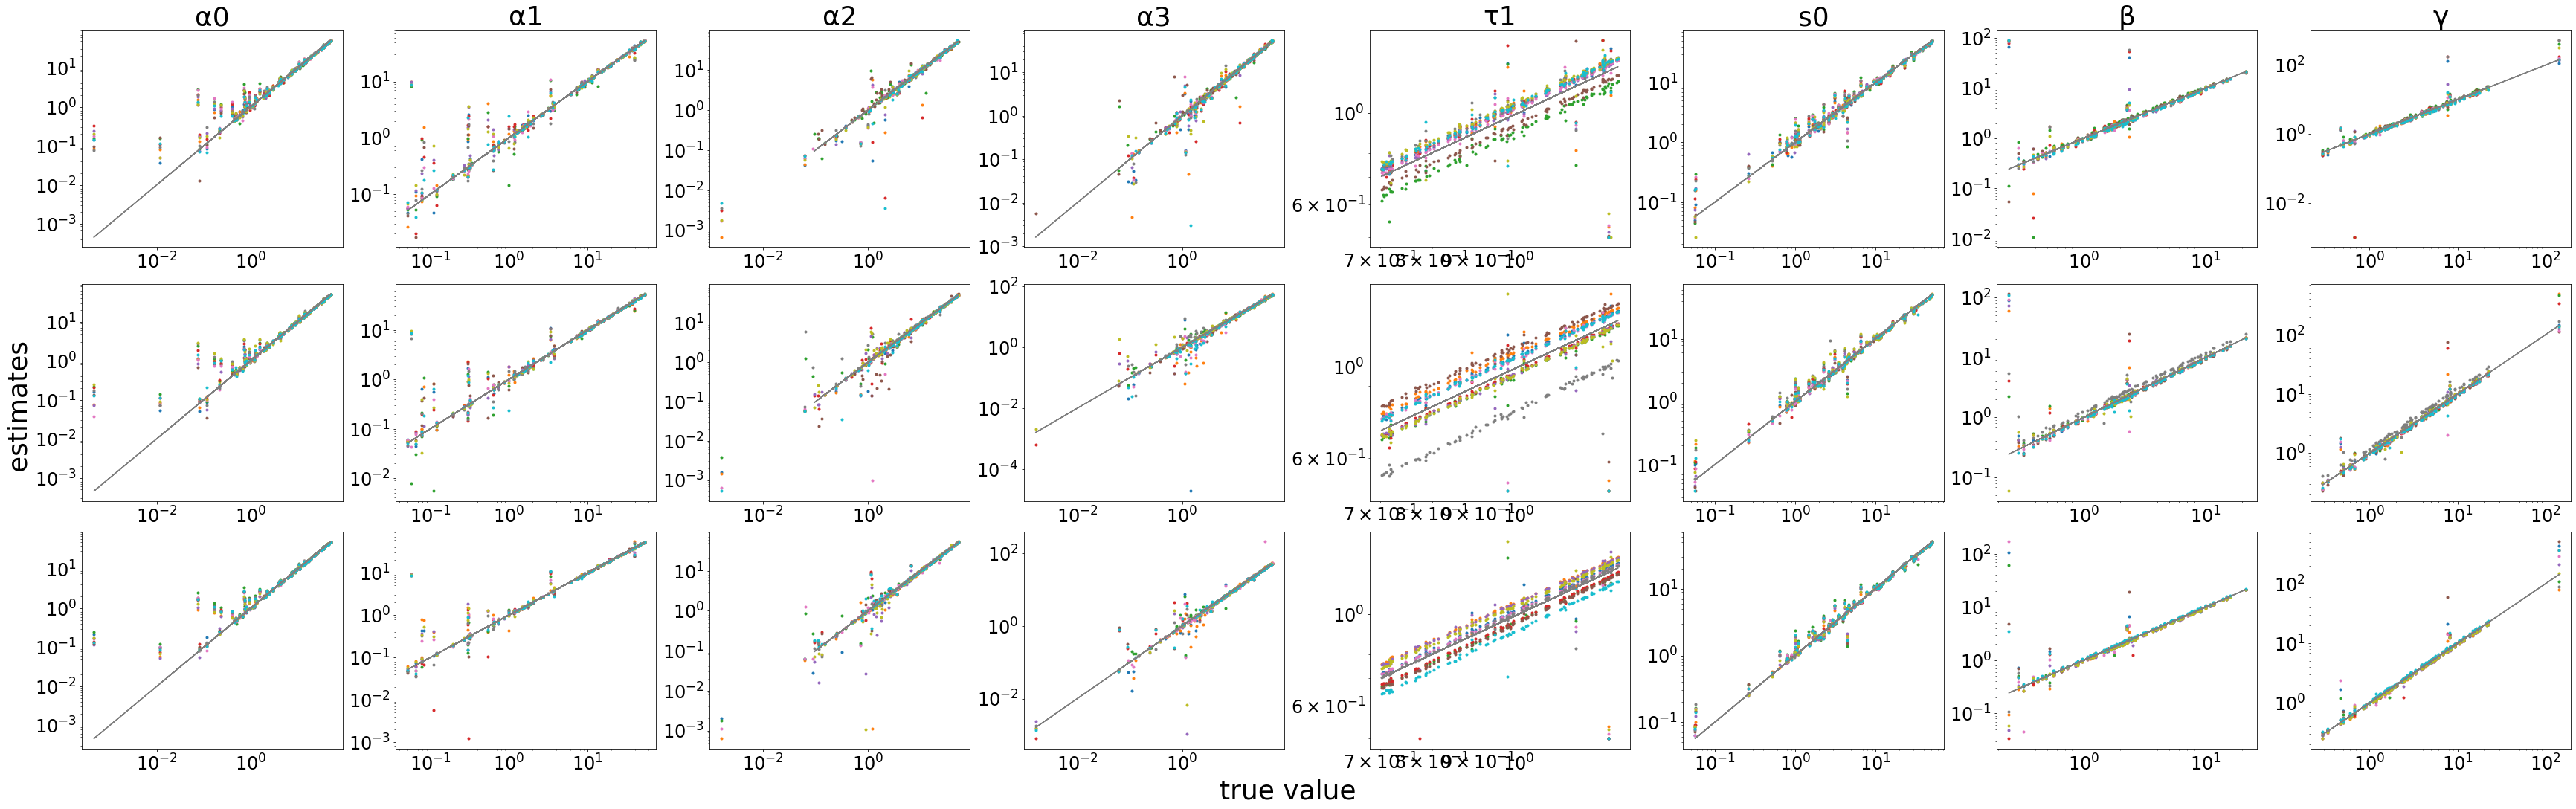

In [76]:
fig = plot_theta_results(results_dir+'topo_4_vary_n_1.pickle')

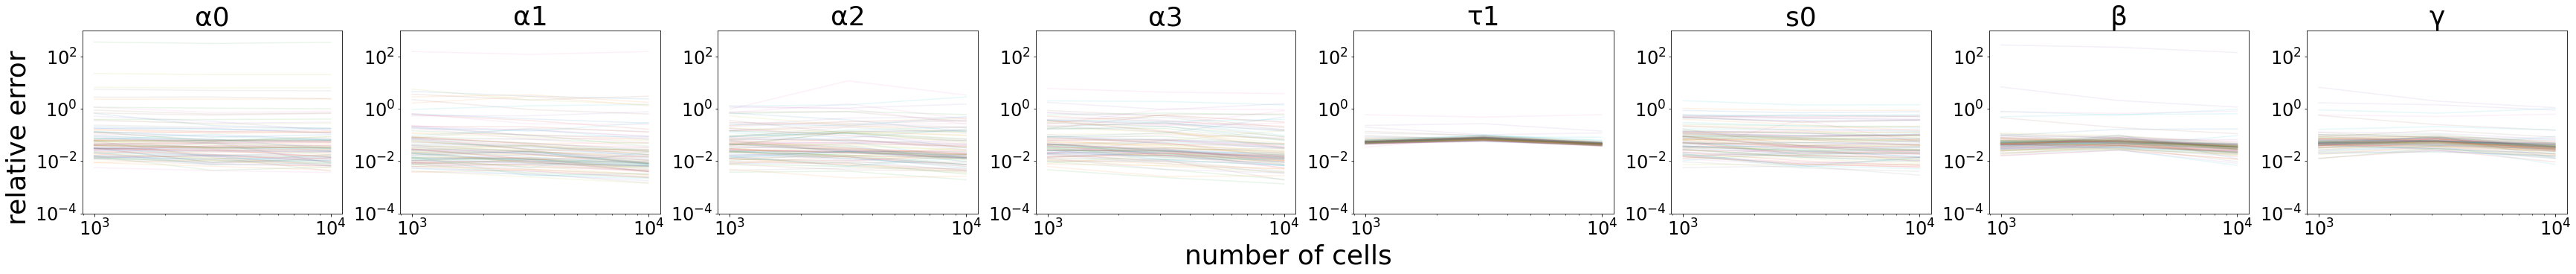

In [87]:
fig = plot_vary_n_results(results_dir+'topo_4_vary_n_1.pickle', ns=[1000,3162,10000], K=10,llim=1e-4,hlim=1e3)

### topo 4 vary p

In [42]:
topo = np.array([[0,1,2],[0,1,]])
tau = (0,1)
results = fit_vary_p_fixed(topo, tau, n=1000, ps=[31,100,316], seed=1, K=10, n_init=15, m=100, epoch=10, cores=30)

with open(results_dir+'topo_4_vary_p_1.pickle', 'wb') as f:
    pickle.dump(results, f, pickle.HIGHEST_PROTOCOL)

n_init =  20


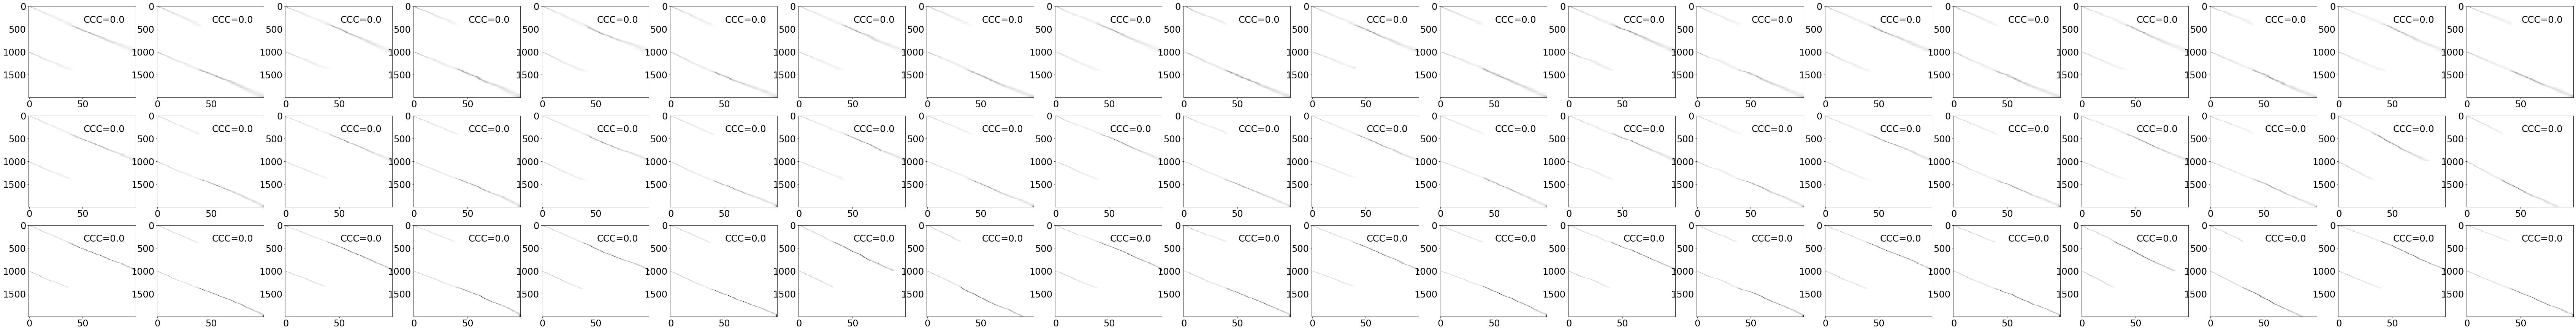

In [78]:
fig = plot_t_results(results_dir+'topo_4_vary_p_1.pickle')

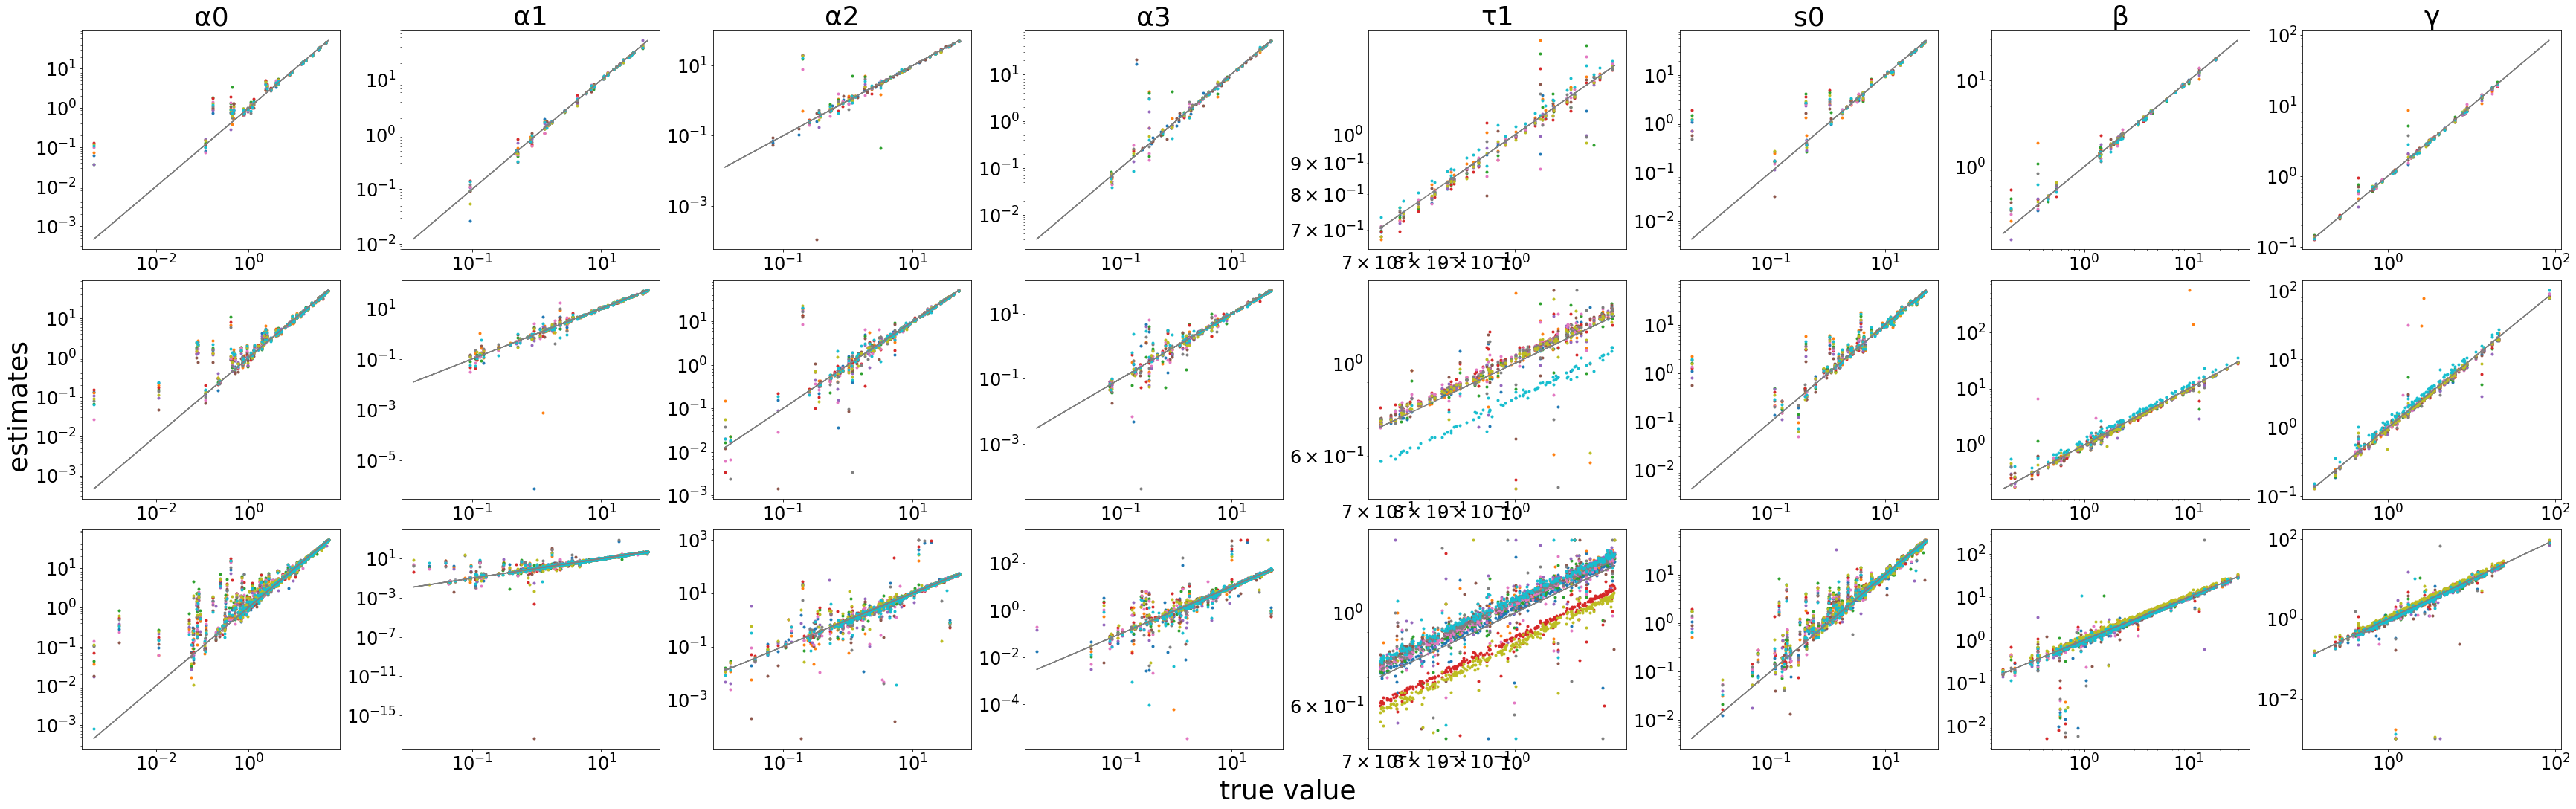

In [79]:
fig = plot_theta_results(results_dir+'topo_4_vary_p_1.pickle')

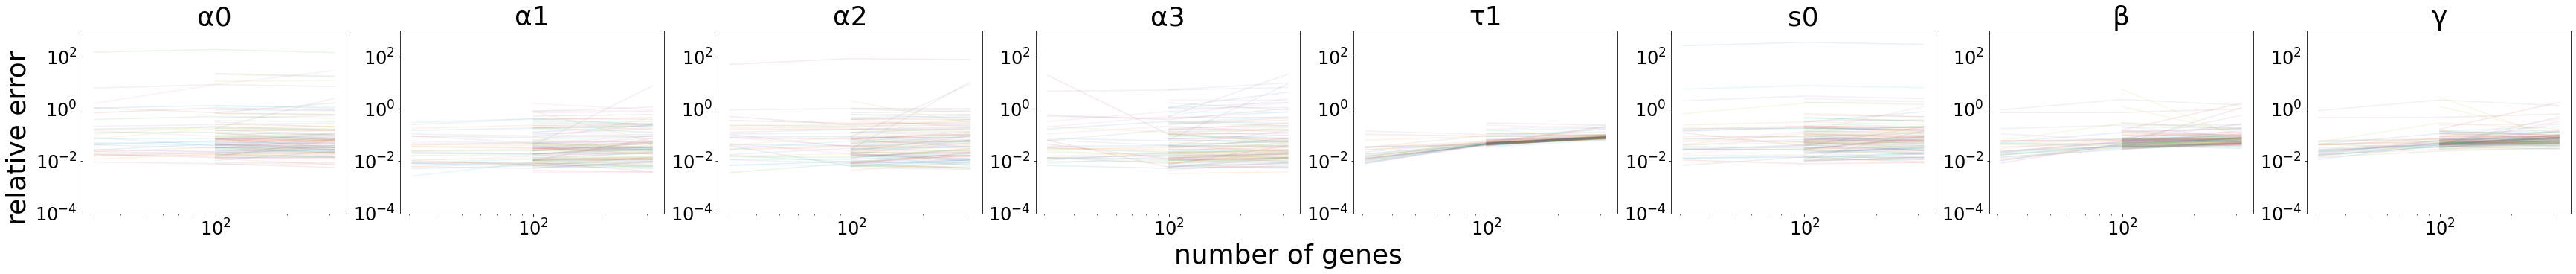

In [88]:
fig = plot_vary_p_results(results_dir+'topo_4_vary_p_1.pickle',K=10)

# Model selection

## null genes

In [18]:
import numpy as np

def simulate_data_with_null(topo, tau, n, p, null = 0.5, loga_max=4, logb_max=2, random_seed=42):
    np.random.seed(random_seed)
    L=len(topo)
    n_states=len(set(topo.flatten()))
    t=np.linspace(tau[0],tau[-1],n)
    true_t = []
    
    theta=np.zeros((p,n_states+4))
    for j in range(n_states+2):
        theta[:,j]=np.exp(np.random.uniform(0,loga_max,size=p))-1
    theta[:,-2]=np.exp(np.random.uniform(0,logb_max,size=p))
    theta[:,-1]=np.exp(np.random.uniform(0,logb_max,size=p))

    null_p = int(p*null)
    theta[:null_p,1]=theta[:null_p,0]
    theta[:null_p,-4]=theta[:null_p,0]
    theta[:null_p,-2]=1
    theta[:null_p,-1]=theta[:null_p,-4]/theta[:null_p,-3]

    Y = np.zeros((n*L,p,2))
    for l in range(L):
        theta_l = np.concatenate((theta[:,topo[l]], theta[:,-4:]), axis=1)
        Y[l*n:(l+1)*n] = get_Y(theta_l,t,tau) # m*p*2
        true_t = np.append(true_t,t)

    X = np.random.poisson(Y)
    return theta, true_t, Y, X

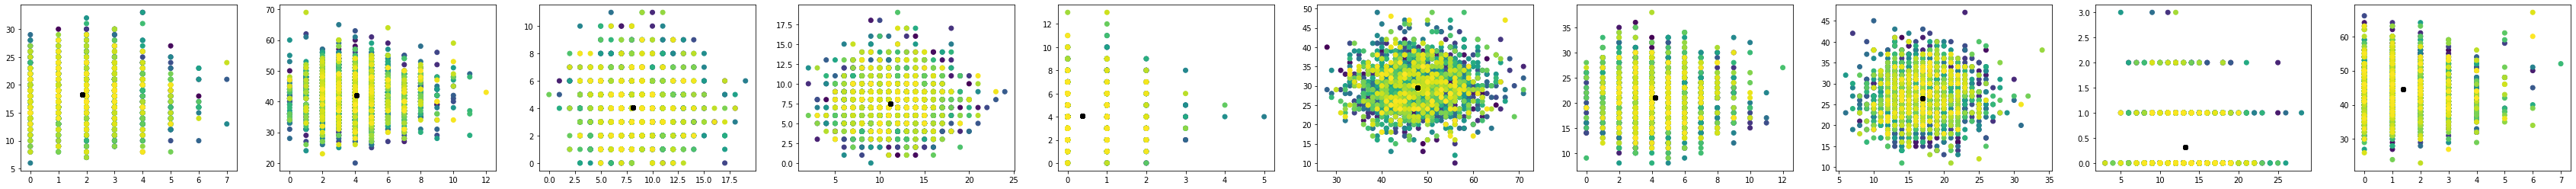

In [21]:
#%% generate data
topo = np.array([[0]])
tau = (0,1)
true_theta, t, Y, X = simulate_data_with_null(topo,tau,n=2000,p=200,random_seed=2023)

t = np.linspace(0,1,2000)
plot_p = 10
fig, ax = plt.subplots(1,plot_p,figsize=(6*plot_p,4))
for i in range(plot_p):
    j = 90 + i
    ax[i].scatter(X[:,j,0],X[:,j,1],c=t);
    ax[i].scatter(Y[:,j,0],Y[:,j,1],c='black');


In [20]:
traj = Trajectory(topo, tau)
res = traj.fit_multi_init(X,100,n_init=2,epoch=10,parallel=True,n_threads=2)

trial 1


100%|██████████| 10/10 [00:20<00:00,  2.08s/it]

trial 2



100%|██████████| 10/10 [00:17<00:00,  1.73s/it]


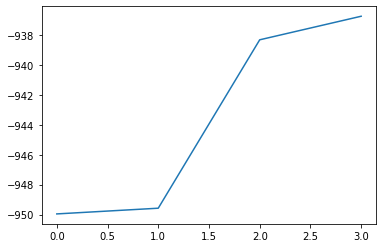

In [22]:
Q, elbos = res
plt.plot(elbos);

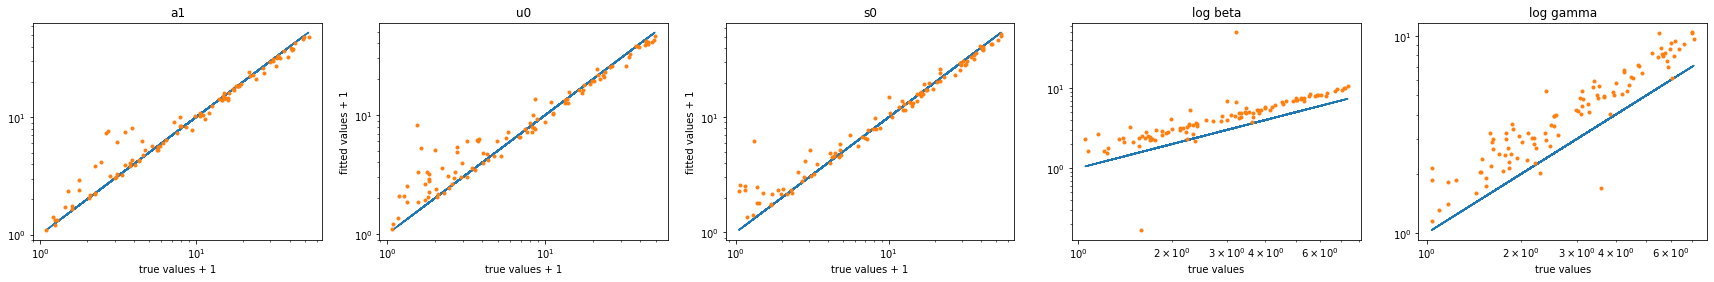

In [23]:
plot_theta(true_theta[100:],traj.theta[100:])

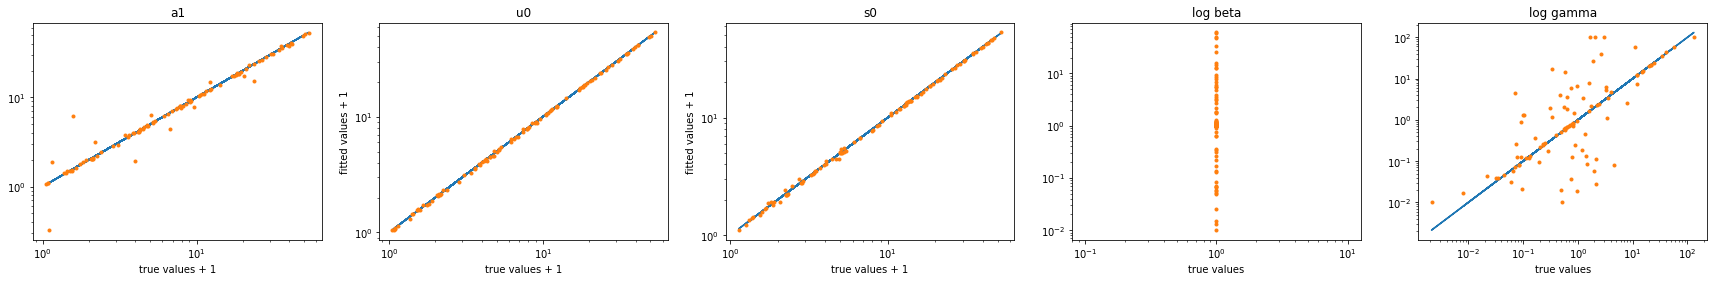

In [24]:
plot_theta(true_theta[:100],traj.theta[:100])

In [ ]:
plot_phase(X,traj.theta[:20],Q,topo,tau)

In [25]:
accepts = []
diffs = []
true_positive = 0
for j in range(100):
    nested_model = {j:[[0,-3],[-4,-4]]}
    accept, diff = traj.compare_model(X, nested_model)
    true_positive += accept
    accepts.append(accept)
    diffs.append(diff)


In [28]:
accepts = []
diffs = []
false_positive = 0
for j in range(100,200):
    nested_model = {j:[[0,-3],[-4,-4]]}
    accept, diff = traj.compare_model(X, nested_model)
    false_positive += accept
    accepts.append(accept)
    diffs.append(diff)


In [29]:
true_positive,false_positive

(95, 0)

## Partially changing genes

In [ ]:
import numpy as np

def simulate_data_with_partial_null(topo, tau, n, p, null_p = 10, loga_max=4, logb_max=2, random_seed=42):
    np.random.seed(random_seed)
    L=len(topo)
    n_states=len(set(topo.flatten()))
    assert n_states > 1
    t=np.linspace(tau[0],tau[-1],n)
    true_t = []
    
    theta=np.zeros((p,n_states+4))
    for j in range(n_states+2):
        theta[:,j]=np.exp(np.random.uniform(0,loga_max,size=p))-1
    theta[:,-2]=np.exp(np.random.uniform(0,logb_max,size=p))
    theta[:,-1]=np.exp(np.random.uniform(0,logb_max,size=p))

    theta[:null_p,1]=theta[:null_p,0]

    Y = np.zeros((n*L,p,2))
    for l in range(L):
        theta_l = np.concatenate((theta[:,topo[l]], theta[:,-4:]), axis=1)
        Y[l*n:(l+1)*n] = get_Y(theta_l,t,tau) # m*p*2
        true_t = np.append(true_t,t)

    X = np.random.poisson(Y)
    return theta, true_t, Y, X

In [ ]:
#%% generate data
topo = np.array([[0,1]])
tau = (0,0.5,1)
true_theta, t, Y, X = simulate_data_with_partial_null(topo,tau,n=2000,p=100,random_seed=2023)

p = 20
fig, ax = plt.subplots(1,p,figsize=(6*p,4))
for i in range(p):
    ax[i].set_title(str(i));
    ax[i].scatter(X[:,i,0],X[:,i,1],c=t);
    ax[i].scatter(Y[:,i,0],Y[:,i,1],c='black');
# time increases from blue to yellow

In [ ]:
traj = Trajectory(topo, tau)
res = traj.fit_multi_init(X,100,n_init=10,epoch=10,parallel=True,n_threads=2)

In [ ]:
Q, elbos, thetas = res
plt.plot(elbos);

In [ ]:
plot_theta(true_theta[10:],traj.theta[10:])

In [ ]:
plot_phase(X,traj.theta[:20],Q,topo,tau)

In [ ]:
accepts = []
diffs = []
for j in range(20):
    nested_model = {j:[[1],[0]]}
    accept, diff = traj.compare_model(X, nested_model, parallel=True, n_threads=2)
    accepts.append(accept)
    diffs.append(diff)

In [ ]:
plt.plot(accepts);

In [ ]:
plot_phase(X,traj.new_theta[:20],Q,topo,tau)

In [ ]:
plt.plot(diffs)